In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.datasets import make_blobs

class TwoLayerLinearPerceptron:
    def __init__(self, hidden_units=4, learning_rate=0.1, max_epochs=1000):
        self.hidden_units = hidden_units
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs
        self.W1 = None
        self.b1 = None
        self.W2 = None
        self.b2 = None
        self.loss_history = []
        
    def _relu(self, x):
        """ReLU функция активации"""
        return np.maximum(0, x)
    
    def _relu_derivative(self, x):
        """Производная ReLU"""
        return (x > 0).astype(float)
    
    def _softmax(self, x):
        """Функция softmax для многоклассовой классификации"""
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    
    def initialize_weights(self, input_size, output_size):
        """Инициализация весов"""
        self.W1 = np.random.randn(input_size, self.hidden_units) * 0.1
        self.b1 = np.zeros((1, self.hidden_units))
        self.W2 = np.random.randn(self.hidden_units, output_size) * 0.1
        self.b2 = np.zeros((1, output_size))
    
    def forward_pass(self, X, return_intermediate=False):
        """Прямой проход через сеть"""
        # Скрытый слой с ReLU
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self._relu(self.z1)
        
        # Выходной слой с softmax
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = self._softmax(self.z2)
        
        if return_intermediate:
            return self.z1, self.a1, self.z2, self.a2
        return self.a2
    
    def compute_loss(self, y_pred, y_true):
        """Вычисление кросс-энтропийной потери"""
        m = y_true.shape[0]
        # Убеждаемся, что y_true имеет целочисленный тип
        y_true_int = y_true.astype(int)
        
        # Добавляем маленькое значение для избежания log(0)
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        
        # Вычисление кросс-энтропии
        log_likelihood = -np.log(y_pred[np.arange(m), y_true_int])
        loss = np.sum(log_likelihood) / m
        return loss
    
    def backward_pass(self, X, y, y_pred):
        """Обратное распространение ошибки"""
        m = X.shape[0]
        y_int = y.astype(int)
        
        # Градиент на выходном слое
        dz2 = y_pred.copy()
        dz2[np.arange(m), y_int] -= 1
        dz2 /= m
        
        # Градиенты для весов выходного слоя
        dW2 = np.dot(self.a1.T, dz2)
        db2 = np.sum(dz2, axis=0, keepdims=True)
        
        # Градиент на скрытом слое
        dz1 = np.dot(dz2, self.W2.T) * self._relu_derivative(self.a1)
        
        # Градиенты для весов скрытого слоя
        dW1 = np.dot(X.T, dz1)
        db1 = np.sum(dz1, axis=0, keepdims=True)
        
        return dW1, db1, dW2, db2
    
    def fit(self, X, y):
        """Обучение модели"""
        n_samples, n_features = X.shape
        n_classes = len(np.unique(y))
        
        self.initialize_weights(n_features, n_classes)
        
        for epoch in range(self.max_epochs):
            # Прямой проход
            y_pred = self.forward_pass(X)
            
            # Вычисление потерь
            loss = self.compute_loss(y_pred, y)
            self.loss_history.append(loss)
            
            # Обратный проход
            dW1, db1, dW2, db2 = self.backward_pass(X, y, y_pred)
            
            # Обновление весов
            self.W1 -= self.learning_rate * dW1
            self.b1 -= self.learning_rate * db1
            self.W2 -= self.learning_rate * dW2
            self.b2 -= self.learning_rate * db2
            
            if epoch % 100 == 0:
                accuracy = self.accuracy(X, y)
                if epoch % 200 == 0:
                    print(f"Эпоха {epoch}: Loss = {loss:.4f}, Accuracy = {accuracy:.4f}")
            
            # Ранняя остановка
            if loss < 0.01 or accuracy > 0.99:
                print(f"Обучение завершено на эпохе {epoch + 1}")
                break
    
    def predict(self, X):
        """Предсказание классов"""
        probabilities = self.forward_pass(X)
        return np.argmax(probabilities, axis=1)
    
    def accuracy(self, X, y):
        """Вычисление точности"""
        predictions = self.predict(X)
        return np.mean(predictions == y)


In [10]:
# Визуализация
def plot_mlp_results(model, X, y):
    """Визуализация линейных границ решений"""
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(15, 18))
    
    colors = ['red', 'blue', 'green', 'orange']
    
    # 1. Исходные данные
    for i in range(4):
        ax1.scatter(X[y == i, 0], X[y == i, 1], c=colors[i], 
                   label=f'Class {i}', alpha=0.7)
    ax1.set_title('Исходные данные')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Предсказания
    y_pred = mlp.predict(X)
    ax2.set_title('Предсказания MLP')
    for i in range(4):
        ax2.scatter(X[y_pred == i, 0], X[y_pred == i, 1], 
                          c=colors[i], label=f'Class {i}', alpha=0.7)
    ax2.axhline(y=0, color='k', linestyle='--', alpha=0.3)
    ax2.axvline(x=0, color='k', linestyle='--', alpha=0.3)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Области решений
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    cmap = mcolors.ListedColormap(colors)
    ax3.contourf(xx, yy, Z, alpha=0.3, cmap=cmap, levels=3)
    for i in range(4):
        ax3.scatter(X[y == i, 0], X[y == i, 1], c=colors[i], alpha=0.7)
    ax3.set_title('Области решений сети')
    ax3.grid(True, alpha=0.3)
    
    # 4. История обучения
    ax4.plot(model.loss_history)
    ax4.set_title('История обучения')
    ax4.set_xlabel('Эпоха')
    ax4.set_ylabel('Потери')
    ax4.grid(True, alpha=0.3)
    
    # 5. Линейные разделители скрытого слоя
    ax5.set_title('Разделители скрытого слоя')
    ax5.set_xlim(x_min, x_max)
    ax5.set_ylim(y_min, y_max)
    
    # Визуализируем разделители скрытого слоя
    for i in range(model.W1.shape[1]):
        w1, w2 = model.W1[:, i]
        b = model.b1[0, i]
        
        if abs(w2) > 1e-6:  # Избегаем деления на ноль
            # Уравнение: w1*x + w2*y + b = 0 => y = (-w1*x - b)/w2
            y_boundary = (-w1 * xx[0] - b) / w2
            ax5.plot(xx[0], y_boundary, '--', alpha=0.7, 
                    label=f'Neuron {i+1}')
    
    for i in range(4):
        ax5.scatter(X[y == i, 0], X[y == i, 1], c=colors[i], alpha=0.5, s=30)

    ax5.legend()
    ax5.grid(True, alpha=0.3)

    # 5. Предсказания vs Фактические значения
    predictions = model.predict(X)
    accuracy = np.mean(predictions == y)
    
    for i in range(4):
        mask = (y == i)
        ax6.scatter(X[mask, 0], X[mask, 1], c=colors[i], 
                    alpha=0.7)
        
        # Подсвечиваем неправильно предсказанные точки
        wrong_mask = mask & (predictions != y)
        if np.any(wrong_mask):
            ax6.scatter(X[wrong_mask, 0], X[wrong_mask, 1], 
                       s=100, linewidth=2, label=f'Ошибка {i}', marker='x', c=colors[i])
    
    ax6.set_title(f'Предсказания (Точность: {accuracy:.4f})')
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle('Перцептрон для 4 классов', y=1.02, fontsize=16)
    plt.show()

Обучение перцептрона ...
Эпоха 0: Loss = 1.3852, Accuracy = 0.3950
Эпоха 200: Loss = 0.4174, Accuracy = 0.9775
Эпоха 400: Loss = 0.1083, Accuracy = 0.9875
Эпоха 600: Loss = 0.0669, Accuracy = 0.9875
Эпоха 800: Loss = 0.0511, Accuracy = 0.9900
Эпоха 1000: Loss = 0.0425, Accuracy = 0.9900
Эпоха 1200: Loss = 0.0369, Accuracy = 0.9925
Обучение завершено на эпохе 1201
Финальная точность: 0.9925


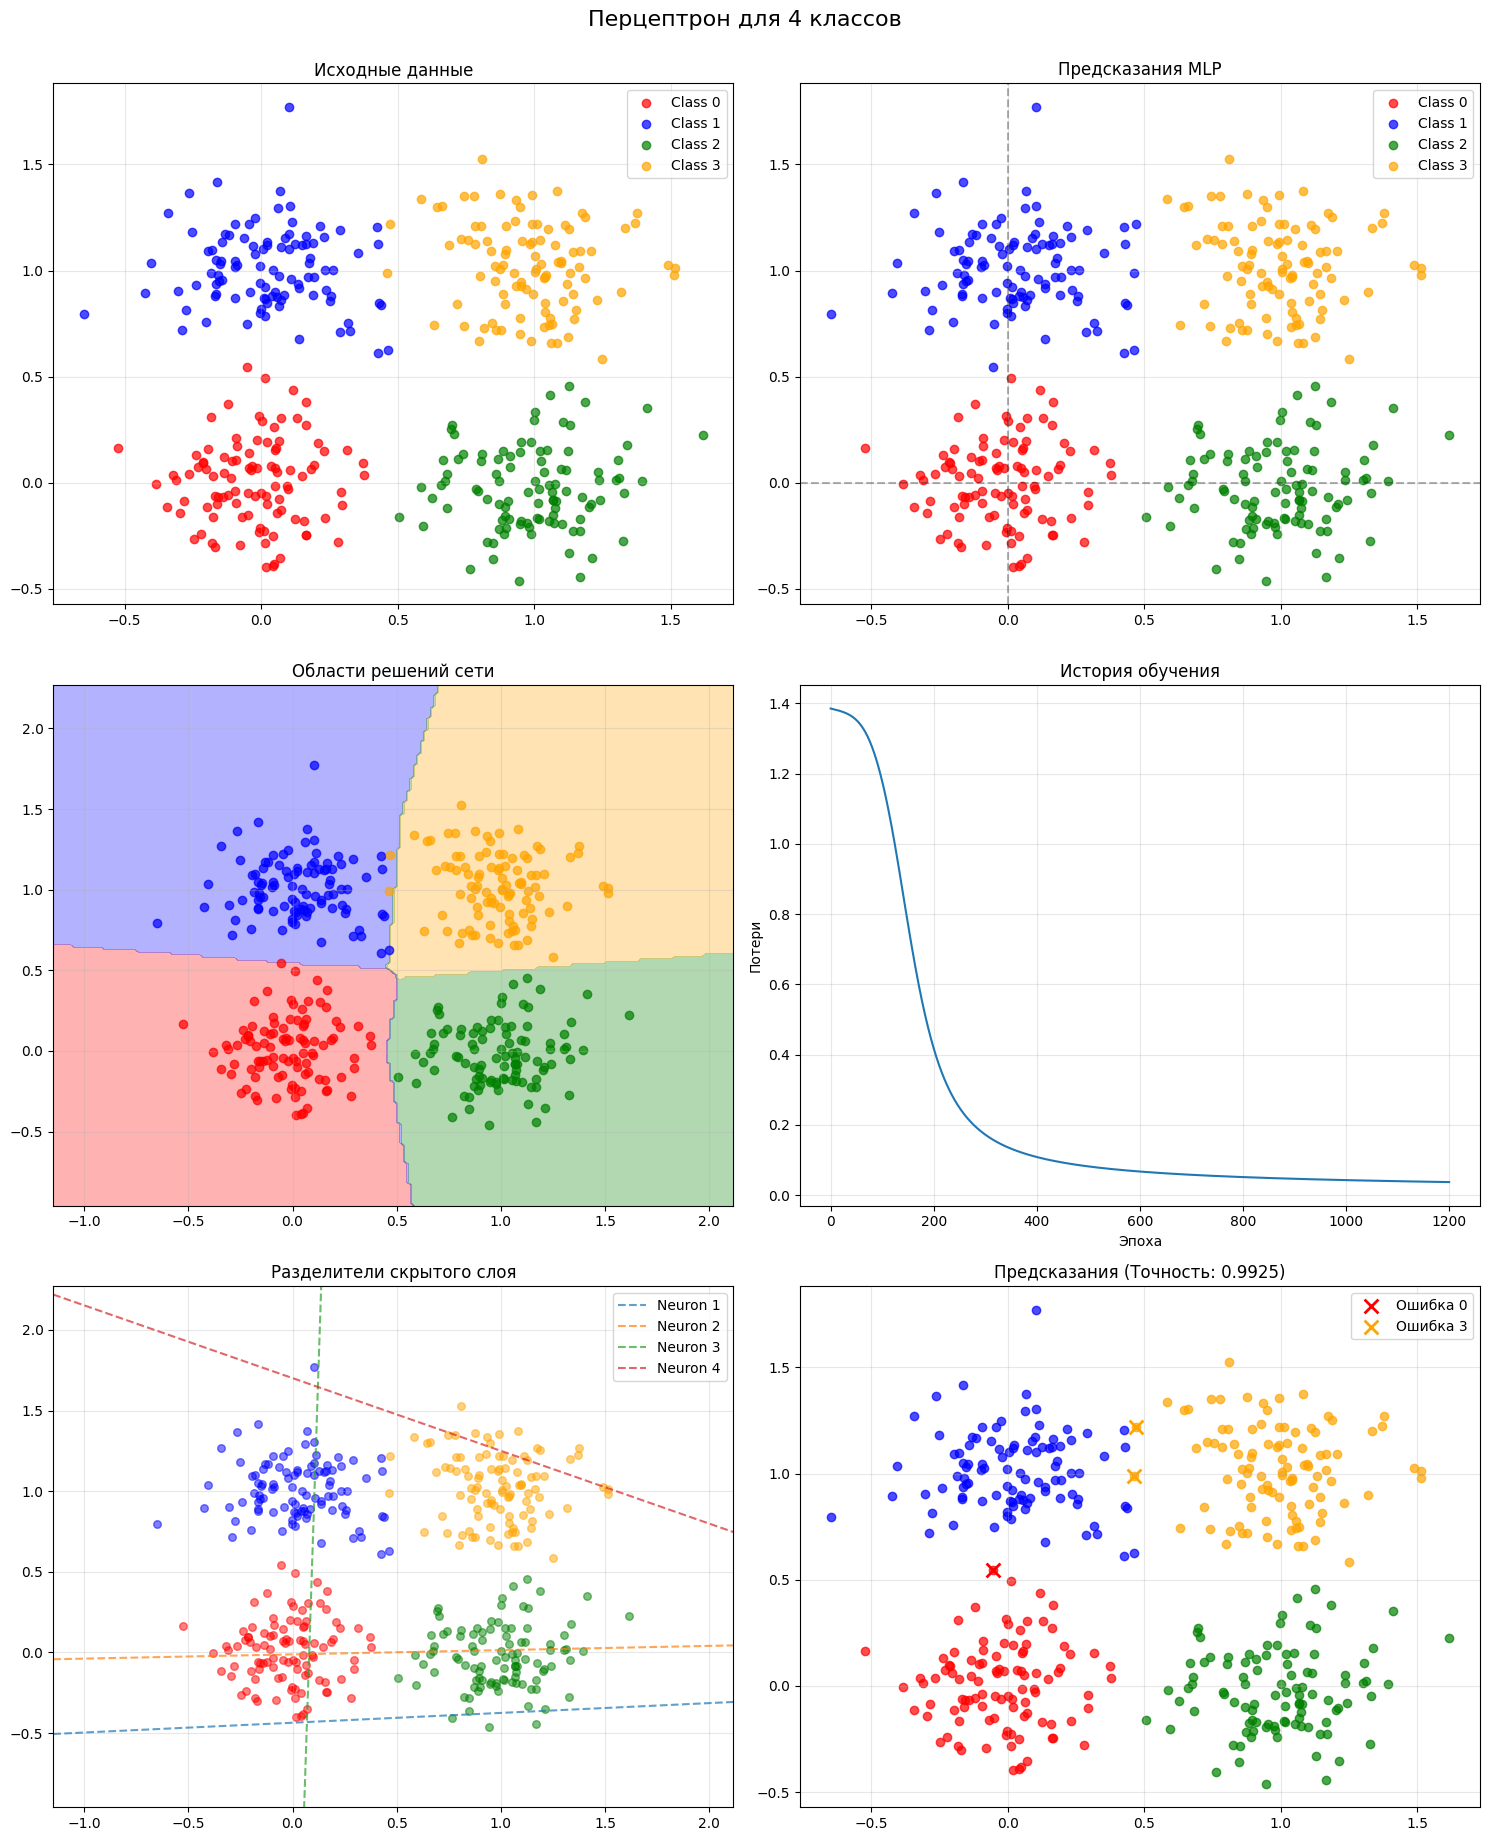

In [12]:
# Обучаем MLP
print("Обучение перцептрона ...")
# Создаем четыре множества точек
centr_1 = [0, 0] # Множество 0
centr_2 = [0, 1] # Множество 1
centr_3 = [1, 0] # Множество 2
centr_4 = [1, 1] # Множество 3

std = 0.2 # рассеяние классов от 0 до 1, чем выше тем классы более пересекаются

X, y = make_blobs(n_samples=400, centers=[centr_1, centr_2, centr_3, centr_4], n_features=2, 
                  random_state=42, cluster_std=std)

mlp = TwoLayerLinearPerceptron(hidden_units=4, learning_rate=0.1, max_epochs=2000)
mlp.fit(X, y)
final_accuracy = mlp.accuracy(X, y)
print(f"Финальная точность: {final_accuracy:.4f}")

# Визуализируем результаты
plot_mlp_results(mlp, X, y)